# Anomaly Detection Using Isolation Forest Algorithm

This notebook follows Analytics Vidhya's blog: [Anomaly Detection Using Isolation Forest Algorithm](https://medium.com/analytics-vidhya/anomaly-detection-using-isolation-forest-algorithm-8cf36c38d6f7) to show how to implement isolation forest.

Three fundamental approaches to detect anomalies are based on:

* **Density**: For density measure, 'Normal points occur in dense regions, while anomalies occur in sparse regions'. e.g RNN and one-class SVM.

* **Distance**: 'Normal point is close to its neighbors and anomaly is far from its neighbors'. e.g Cluster based method.

* **Isolation**: The term isolation means separating an instance from the rest of the instances’. Since anomalies are **few and different** and therefore they are more susceptible to isolation.


## What is isolation forest?

The Isolation Forest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

It is an unsupervised algorithm and therefore it does not need labels to identify the outlier/anomaly.

It follows the following steps:
1. Random and recursive partition of data is carried out, which is represented as a tree (random forest). This is the training stage where the user defines the parameters of the subsample and the number of trees.
2. The end of the tree is reached once the recursive partition of data is finished. It is expected that the **path distance taken to reach the outlier is far less than that for the normal data**.
3. The distance of the path is **averaged** and normalized to calculate the anomaly score.
4. The judgment of the outlier is carried out on the basis of the score.


## Data description:

The data set which we are using is [Http dataset](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) from the KDDCUP in 1999.
The dataset contains 623091 HTTP connection records from seven weeks of network traffic.
The dataset is already preprocessed and contains 41 features of the individual TCP connections, content features, and traffic features.
Each connection is labeled as either normal or as an attack, with exactly one specific attack type.

**NOTE**: Use gunzip to unzip the xxx.gz files.

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [151]:
cols = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
        'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 
        'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 
        'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
        'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
        'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
        'dst_host_srv_rerror_rate']

df = pd.read_csv('train_data.csv', sep=",", names=cols + ['label'], index_col=None)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898431 entries, 0 to 4898430
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     int64  
 1   protocol_type                object 
 2   service                      object 
 3   flag                         object 
 4   src_bytes                    int64  
 5   dst_bytes                    int64  
 6   land                         int64  
 7   wrong_fragment               int64  
 8   urgent                       int64  
 9   hot                          int64  
 10  num_failed_logins            int64  
 11  logged_in                    int64  
 12  num_compromised              int64  
 13  root_shell                   int64  
 14  su_attempted                 int64  
 15  num_root                     int64  
 16  num_file_creations           int64  
 17  num_shells                   int64  
 18  num_access_files             int64  
 19  

In [147]:
test_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,udp,private,SF,105,146,0,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
0,udp,private,SF,105,146,0,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
0,udp,private,SF,105,146,0,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
0,udp,private,SF,105,146,0,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
0,udp,private,SF,105,146,0,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.


In [153]:
df = df[df.service == "http"]
df = df.drop(["service"], axis=1)
cols.remove("service")

In [156]:
len(df), len(df[df.label == "normal."])

(623091, 619046)

In [21]:
set(df["label"])

{'back.',
 'ipsweep.',
 'neptune.',
 'nmap.',
 'normal.',
 'phf.',
 'portsweep.',
 'satan.'}

## Encoding the categorical column 

In [157]:
from sklearn.preprocessing import LabelEncoder

encs = dict()
for c in df_1.columns:
    if df[c].dtype == 'object':
        encs[c] = LabelEncoder()
        df[c] = encs[c].fit_transform(df[c])
        if c != 'label':
            test_df[c] = encs[c].fit_transform(test_df[c])

In [158]:
#### Implementing Isolation forest 
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

#### Spliting the data into Train, Test and validation dataset 

df = df.sample(frac=1.0)

# X_train, y_train = df[cols][:300000], df['label'][:300000].values
# X_val, y_val = df[cols][300000:500000], df['label'][300000:500000].values
# X_test, y_test = df[cols][500000:], df['label'][500000:].values

X_train, X_test, y_train, y_test = train_test_split(df[cols], df['label'], test_size=0.3, random_state=42)

In [159]:
X_train.shape

(436163, 40)

## Isolation forest parameter

* **n_estimators (default=100)**: The number of trees to use. The paper suggests an number of 100 trees, because the path lengths usually converges well before that.


* **max_samples (default=”auto”)**: The number of samples to draw while build a single tree. The number of samples to draw from X to train each base estimator. If max_samples is larger than the number of samples provided, all samples will be used for all trees (no sampling).
   * If int, then draw max_samples samples.
   * If float, then draw max_samples * X.shape[0] samples.
   * If “auto”, then max_samples=min(256, n_samples).
   


* **contamination**: The amount of contamination of the data set, i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the decision function. I will show you how to pick this treshold later.


* **max_features (default=1.0)**:  The number of features to draw from X to train each base estimator.
   * If int, then draw max_features features.
   * If float, then draw max_features * X.shape[1] features.



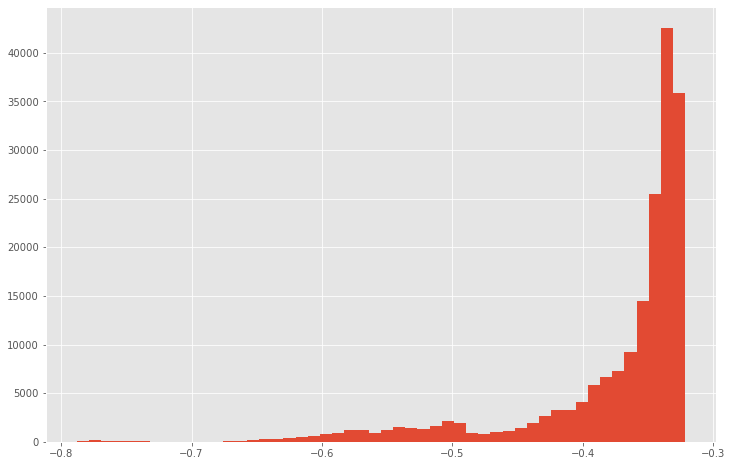

In [160]:
### Building isolation forest 
iforest = IsolationForest(n_estimators=100, max_samples=256, contamination=0.4, random_state=2018)

## Fitting the model 
iforest.fit(X_train)

#### Ploting the graph to identify the anomolie score .
plt.figure(figsize=(12, 8))
plt.hist(iforest.score_samples(X_test), bins=50);

In [161]:
from sklearn.metrics import roc_auc_score
print('AUC: {:.1%}'.format(roc_auc_score((-0.7 < iforest.score_samples(X_test)), \
                                         y_test == list(encs['label'].classes_).index('normal.'))))

AUC: 99.5%


In [164]:
X_train.shape, X_test.shape

((436163, 40), (186928, 40))

## Grid Search on Isolation Forest

Stackoverflow blog: [Isolation Forest Parameter tuning with gridSearchCV](https://stackoverflow.com/questions/56078831/isolation-forest-parameter-tuning-with-gridsearchcv)

In [104]:
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection

clf = IsolationForest(random_state=47)

param_grid = {'n_estimators': [100, 150], 
              'max_samples': [100, 200, 256], 
              'contamination': [0.2, 0.4], 
              'bootstrap': [True, False]}

f1sc = make_scorer(f1_score, average='micro')

grid_dt_estimator = model_selection.GridSearchCV(clf, 
                                                 param_grid,
                                                 scoring=f1sc, 
                                                 refit=True,
                                                 cv=5, 
                                                 return_train_score=True)
grid_dt_estimator.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=IsolationForest(random_state=47),
             param_grid={'bootstrap': [True, False],
                         'contamination': [0.2, 0.4],
                         'max_samples': [100, 200, 256],
                         'n_estimators': [100, 150]},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=micro))

In [105]:
grid_dt_estimator.best_estimator_

IsolationForest(bootstrap=True, contamination=0.2, max_samples=100,
                random_state=47)

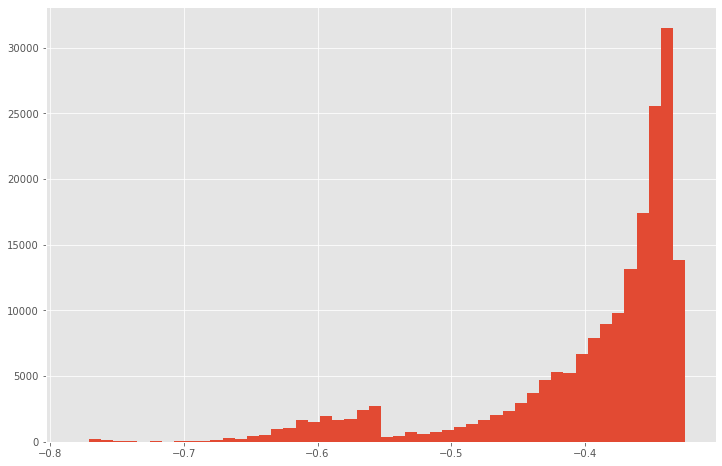

In [166]:
plt.figure(figsize=(12, 8))
plt.hist(grid_dt_estimator.score_samples(X_test), bins=50);

In [167]:
print('AUC: {:.1%}'.format(roc_auc_score((-0.71 < grid_dt_estimator.score_samples(X_test)), \
                                         y_test == list(encs['label'].classes_).index('normal.'))))

AUC: 99.3%
